# Segmentación de Empleados de la Contraloría General de la República Dominicana (2018-2025)

**Objetivo:** Identificar grupos naturales de empleados según sueldo, estatus, función y departamento

**Autores:** Scarlet Abreu y Renso Peralta

#### Importar Librerías

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

#### Cargar el dataset

In [43]:
OUTPUT_DIR = "C:\\Users\\Scarlet\\Downloads\\DW"
df = pd.read_csv(f"{OUTPUT_DIR}/merged_empleados.csv")

#### Mostrar las primeras filas y Resumen estadístico

In [44]:
print("Primeras filas del dataset:")
print(df.head())
print("\nResumen estadístico:")
print(df.describe())

Primeras filas del dataset:
   EMPLEADO_ID  DEPARTAMENTO_ID  FUNCION_ID  ESTATUS_ID  TIEMPO_ID   SUELDO  \
0            1                1           1           1          1  35000.0   
1            2                1           1           1          1  35000.0   
2            3                1           1           1          1  35000.0   
3            4                1           1           1          1  35000.0   
4            5                1           1           1          1  35000.0   

               NOMBRE_EMPLEADO        NOMBRE_DEPARTAMENTO  \
0         RAQUEL MENDEZ PUJOLS  AUXILIAR ADMINISTRATIVO A   
1       ROCIO LOPEZ CORTORREAL  AUXILIAR ADMINISTRATIVO A   
2      ROSMARY CONTRERAS UREÑA  AUXILIAR ADMINISTRATIVO A   
3  ROLANDO ANTONIO SUSAÑA PEÑA  AUXILIAR ADMINISTRATIVO A   
4        SAUL SANTANA PIMENTEL  AUXILIAR ADMINISTRATIVO A   

                                      NOMBRE_FUNCION NOMBRE_ESTATUS  MES  \
0  DIRECCION DE UNIDADES AUDITORIA INTERNA GUBERN...  

#### Distribución de sueldos (histograma)

#### La funcion histplot se usa para crear histogramas. Divide los datos en intervalos (bins), en este caso 20 y representa la densidad de los puntos de datos en cada intervalo

#### El parametro kde muestra una linea que representa la distribucion de los datos en una curva suave, en este caso toma True para mostrar dicha curva.

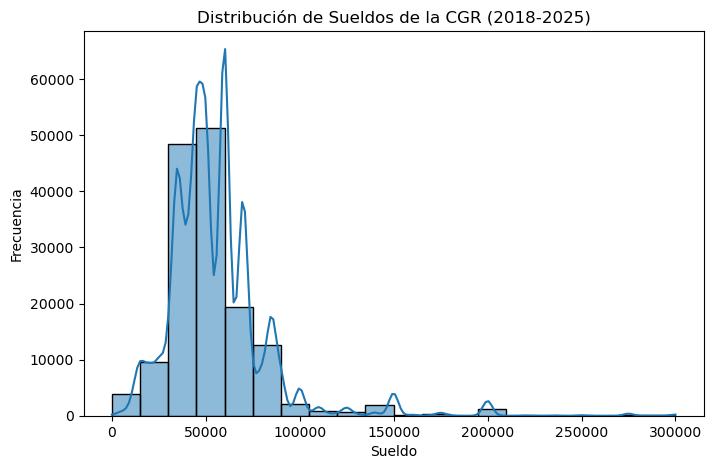

In [45]:
plt.figure(figsize=(8, 5))
sns.histplot(df['SUELDO'], bins=20, kde=True)
plt.title('Distribución de Sueldos de la CGR (2018-2025)')
plt.xlabel('Sueldo')
plt.ylabel('Frecuencia')
plt.show()

#### Preparar los datos para clustering

#### La funcion groupby divide un conjunto de datos basado en ciertos criterios, en este caso, los datos se agrupan por el ID del empleado. La funcion agg se usa para agrupar los datos en un Dataframe, en este caso lo organizamos por sueldo, nombre del empleado, estatuso, funcion y su repectivo departamento.

#### La funcion reset_index se organiza los indices por si se desordenan al momento de hacer el nuevo data frame.

In [46]:
## Agrupar por empleado único para evitar duplicados
df_agg = df.groupby('EMPLEADO_ID').agg({
    'SUELDO': 'mean',
    'NOMBRE_EMPLEADO': 'first',
    'NOMBRE_ESTATUS': 'first',
    'NOMBRE_FUNCION': 'first',
    'NOMBRE_DEPARTAMENTO': 'first'
}).reset_index()

#### Borrar columnas de IDs irrelevantes para el clustering

#### La funcion drop toma un Dataframe y elimina las filas o columnas que se le asignen, el otro parametro errors ignora o omite las etiquetas que no se encuentren y evitar un error.

In [47]:
df_agg = df_agg.drop(columns=['DEPARTAMENTO_ID', 'FUNCION_ID', 'ESTATUS_ID', 'TIEMPO_ID'], errors='ignore')

In [48]:
df_agg.head()

,EMPLEADO_ID,SUELDO,NOMBRE_EMPLEADO,NOMBRE_ESTATUS,NOMBRE_FUNCION,NOMBRE_DEPARTAMENTO
0,1,37271.428571,RAQUEL MENDEZ PUJOLS,FIJO,DIRECCION DE UNIDADES AUDITORIA INTERNA GUBERN...,AUXILIAR ADMINISTRATIVO A
1,2,36914.893617,ROCIO LOPEZ CORTORREAL,FIJO,DIRECCION DE UNIDADES AUDITORIA INTERNA GUBERN...,AUXILIAR ADMINISTRATIVO A
2,3,58071.961208,ROSMARY CONTRERAS UREÑA,FIJO,DIRECCION DE UNIDADES AUDITORIA INTERNA GUBERN...,AUXILIAR ADMINISTRATIVO A
3,4,94132.841328,ROLANDO ANTONIO SUSAÑA PEÑA,FIJO,DIRECCION DE UNIDADES AUDITORIA INTERNA GUBERN...,AUXILIAR ADMINISTRATIVO A
4,5,37608.695652,SAUL SANTANA PIMENTEL,FIJO,DIRECCION DE UNIDADES AUDITORIA INTERNA GUBERN...,AUXILIAR ADMINISTRATIVO A


#### Categorizar variables

#### La funcion LabelEncoder() convierte texto en numeros. Esto se hizo con el fin de convertir el estatus, funcion y departamento en 'numeros'.

#### Con la funcion fit_transform estamos haciendo el proceso de asignarlos como numeros. El sufijo ENC viene de Encoded. Ahora cada una de estas columnas, tienen numeros en vez de texto

In [49]:
label_estatus = LabelEncoder()
label_funcion = LabelEncoder()
label_departamento = LabelEncoder()

df_agg['ESTATUS_ENC'] = label_estatus.fit_transform(df_agg['NOMBRE_ESTATUS'])
df_agg['FUNCION_ENC'] = label_funcion.fit_transform(df_agg['NOMBRE_FUNCION'])
df_agg['DEP_ENC'] = label_departamento.fit_transform(df_agg['NOMBRE_DEPARTAMENTO'])

# Variables para clustering
df_features = df_agg[['SUELDO', 'ESTATUS_ENC', 'FUNCION_ENC', 'DEP_ENC']]

#### La funcion StandardScaler() se encarga de normalizar los datos para que tengan media = 0 y desv. estandar = 1. Esto se hace con el fin de mantener una escala similar para cada columna

In [50]:
# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

#### Matriz de correlación

#### La funcion corr toma el dataframe feature y saca su correlacion, ya sea positiva o negativa de 0 a 1. 

#### La funcion heatmap, como su nombre lo dice, hace un mapa de calor. Toma como parametros el dataframe, en este caso la correlacion (valores entre -1, 0 y 1), el parametro annot en True hace que se muestren los valores en el heat map. El cmap es de color map.

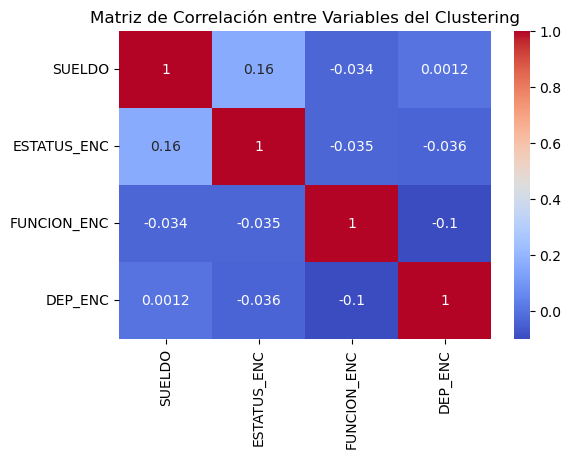

In [51]:
corr = df_features.corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación entre Variables del Clustering')
plt.show()

#### Elegir la cantidad de clusters

#### Primero creamos una lista llamada 'inertia' la cual sirve para guardar incercias. Las incercias es una medida que dicen que tan compactos estan los clusters, mientras mas baja la inercia, mejor agrupados estan los datos.

#### La variable K toma 9 valores. Esto indica la cantidad de clusters a probar.

#### La variable k minuscula es el indice y K es la cantidad de valores a probar. Y por cada iteracion, se agrega con un append los clusters probados a la lista inertia.

#### Luego se crea el grafico del metodo del codo.

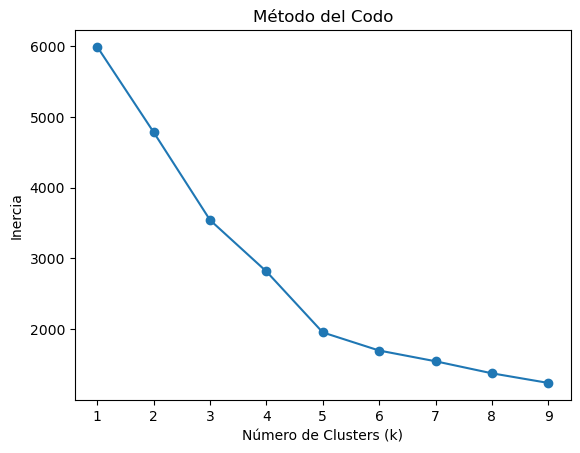

In [52]:
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

#### Entrenar el modelo con k = 5